## Project: Heart Diseases Prediction Model using Machine Learning algorithms



### Import libraries

In [1]:
# data analysis, splitting and wrangling
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Load data

In [3]:
# column names in accordance with feature information
col_names = ['age','sex','chest_pain','blood_pressure','serum_cholestoral','fasting_blood_sugar', 'electrocardiographic',
             'max_heart_rate','induced_angina','ST_depression','slope','no_of_vessels','thal','diagnosis']

# read the file
df = pd.read_csv("processed.cleveland.data", names=col_names, header=None, na_values="?")

print("Number of records: {}\nNumber of variables: {}".format(df.shape[0], df.shape[1]))

# display the first 5 lines
df.head()

Number of records: 303
Number of variables: 14


,age,sex,chest_pain,blood_pressure,serum_cholestoral,fasting_blood_sugar,electrocardiographic,max_heart_rate,induced_angina,ST_depression,slope,no_of_vessels,thal,diagnosis
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   303 non-null    float64
 1   sex                   303 non-null    float64
 2   chest_pain            303 non-null    float64
 3   blood_pressure        303 non-null    float64
 4   serum_cholestoral     303 non-null    float64
 5   fasting_blood_sugar   303 non-null    float64
 6   electrocardiographic  303 non-null    float64
 7   max_heart_rate        303 non-null    float64
 8   induced_angina        303 non-null    float64
 9   ST_depression         303 non-null    float64
 10  slope                 303 non-null    float64
 11  no_of_vessels         299 non-null    float64
 12  thal                  301 non-null    float64
 13  diagnosis             303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


There are only 6 missing values in this dataset and all variables are recognized as numeric. From dataset description, we know, however, that most of features are categorical and it's necessary to distinguish them.

In [5]:
# extract numeric columns and find categorical ones
numeric_columns = ['serum_cholestoral', 'max_heart_rate', 'age', 'blood_pressure', 'ST_depression']
categorical_columns = [c for c in df.columns if c not in numeric_columns]
print(categorical_columns)

['sex', 'chest_pain', 'fasting_blood_sugar', 'electrocardiographic', 'induced_angina', 'slope', 'no_of_vessels', 'thal', 'diagnosis']


## Analyze features, identify patterns, and explore the data

### Target value

Knowing the distribution of target value is vital for choosing appropriate accuracy metrics and consequently properly assess different machine learning models.

In [6]:
# count values of explained variable
df.diagnosis.value_counts()

0    164
1     55
2     36
3     35
4     13
Name: diagnosis, dtype: int64

Since the values 1-4 indicate that a disease is present, it's reasonable to pull them together.

In [7]:
# create a boolean vector and map it with corresponding values (True=1, False=0)
df.diagnosis = (df.diagnosis != 0).astype(int)
df.diagnosis.value_counts()

0    164
1    139
Name: diagnosis, dtype: int64

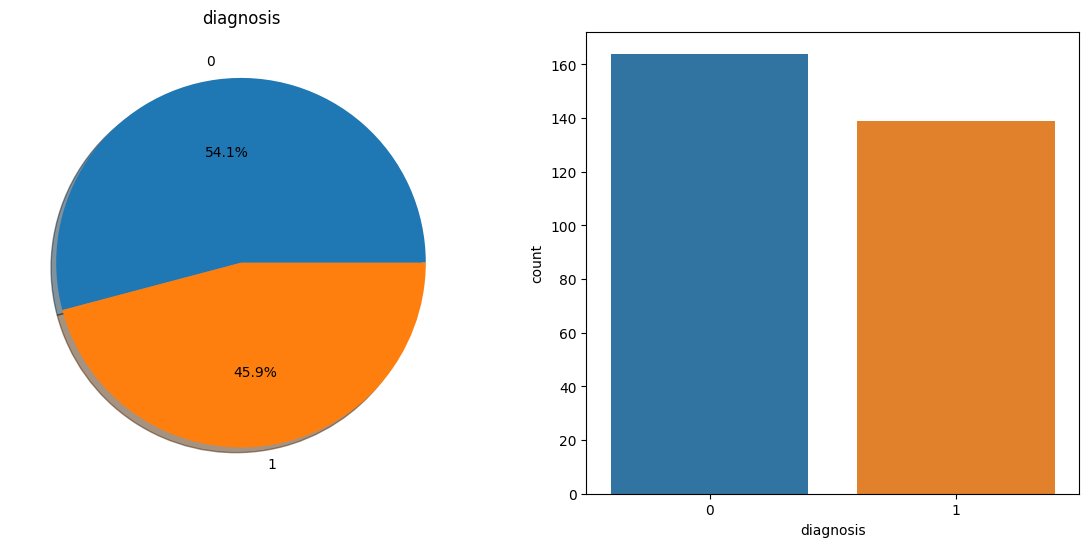

In [8]:
# create two plots side by side
f, ax = plt.subplots(1,2,figsize=(14,6))
df['diagnosis'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('diagnosis')
ax[0].set_ylabel('')
sns.countplot('diagnosis', data=df, ax=ax[1])
plt.show()

Now the distribution of target value is almost equal, so using standard metrics in further machine learning modelling like _accuracy_ and _AUC_ is justified. 

### Numeric features

There are 5 numeric columns, so let's take care of them first. 
Outliers occurrence in the dataset may be a result of wrong input and create undesired noise, thus our role is to evaluate their substance. A data point is considered as an outlier when it falls outside 3 standard deviations. 

In [9]:
# view of descriptive statistics
df[numeric_columns].describe()

,serum_cholestoral,max_heart_rate,age,blood_pressure,ST_depression
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,246.693069,149.607261,54.438944,131.689769,1.039604
std,51.776918,22.875003,9.038662,17.599748,1.161075
min,126.000000,71.000000,29.000000,94.000000,0.000000
25%,211.000000,133.500000,48.000000,120.000000,0.000000
50%,241.000000,153.000000,56.000000,130.000000,0.800000
75%,275.000000,166.000000,61.000000,140.000000,1.600000
max,564.000000,202.000000,77.000000,200.000000,6.200000


All extreme (min/max) values could occur in a real clinical scenario, hence the decision to keep them as they are. 

We can gain some intuition about relationships amongst numeric features by plotting each pair in a scattered form. To do this efficiently, *pairplot* method from Seaborn library comes in handy.

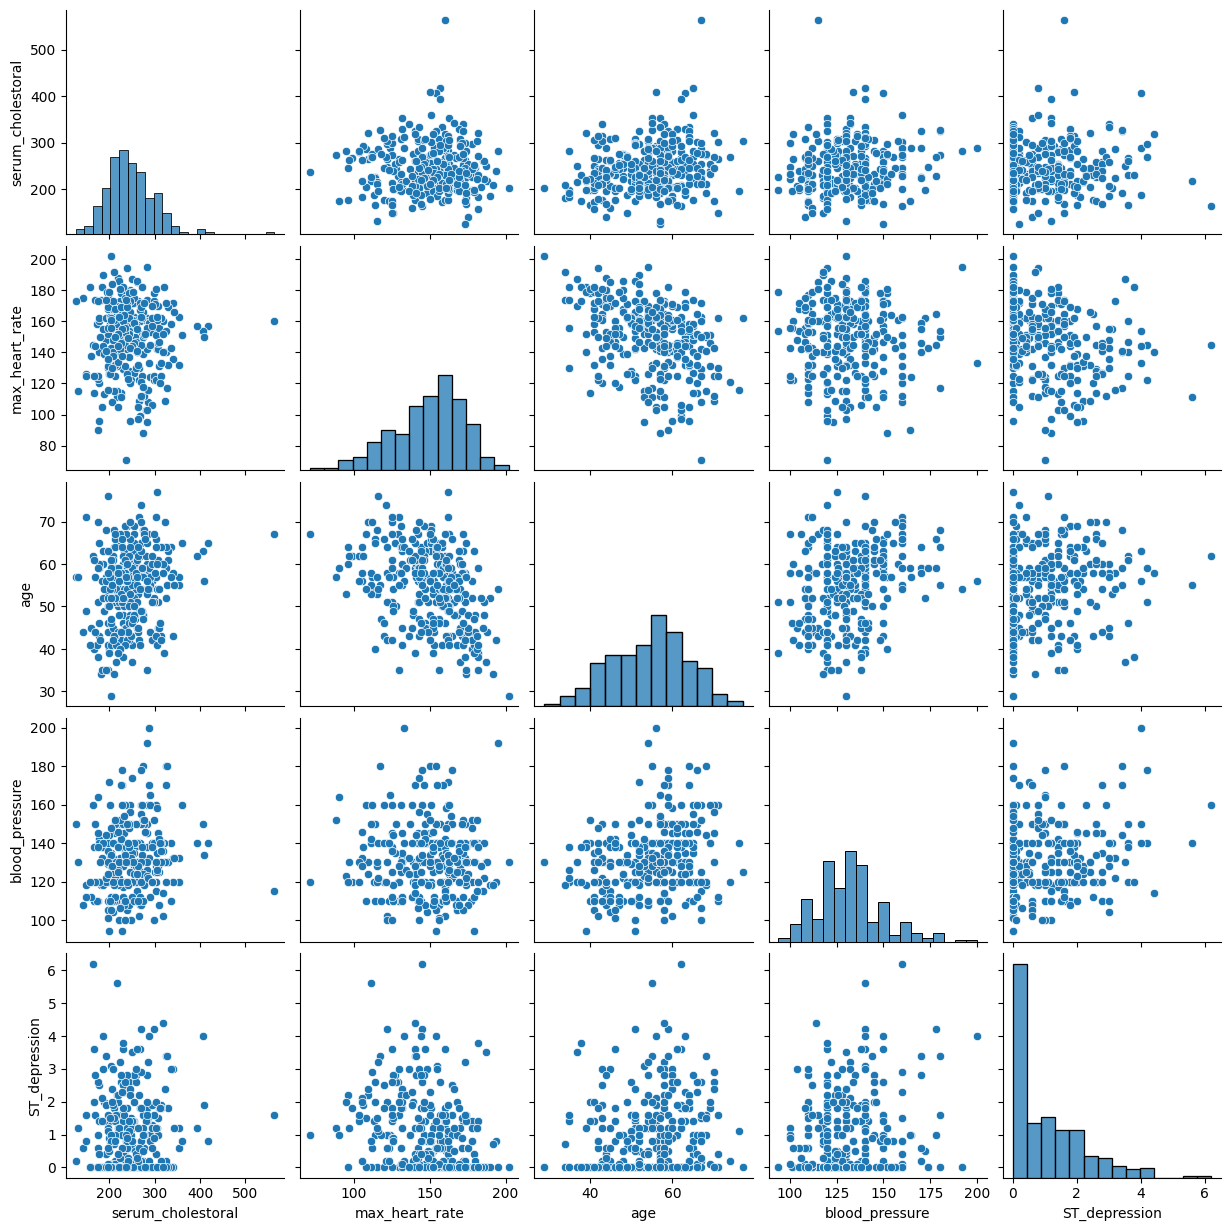

In [10]:
# create a pairplot
sns.pairplot(df[numeric_columns])
plt.show()

Seeing above plots, I infer that none of displayed value pairs is having an explicitly high correlation, so there is no necessity to ditch any feature at this stage. I also notice a negative correlation between 'age' and 'max_heart_rate' and positive correlation between 'age' and 'blood_pressure', what is intuitive.

A correlation matrix will make us sure whether the above is correct.

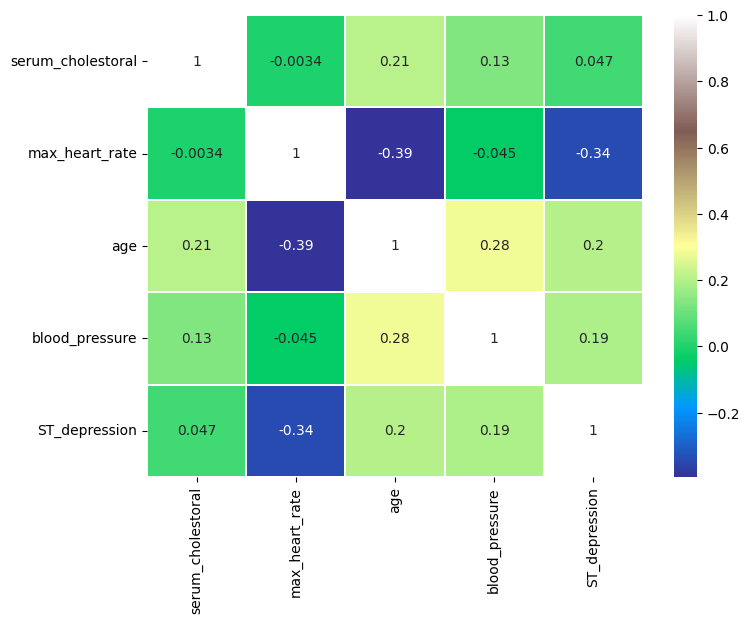

In [11]:
# create a correlation heatmap
sns.heatmap(df[numeric_columns].corr(),annot=True, cmap='terrain', linewidths=0.1)
fig=plt.gcf()
fig.set_size_inches(8,6)
plt.show()

Apart from two aforementioned relations, there is one more important dependency: 'max_heart_rate' and 'ST_depression'. The conclusion comes up that both features, 'age' and 'max_heart_rate', will play an important role in predicting heart disease. Let's take a look at their distributions.

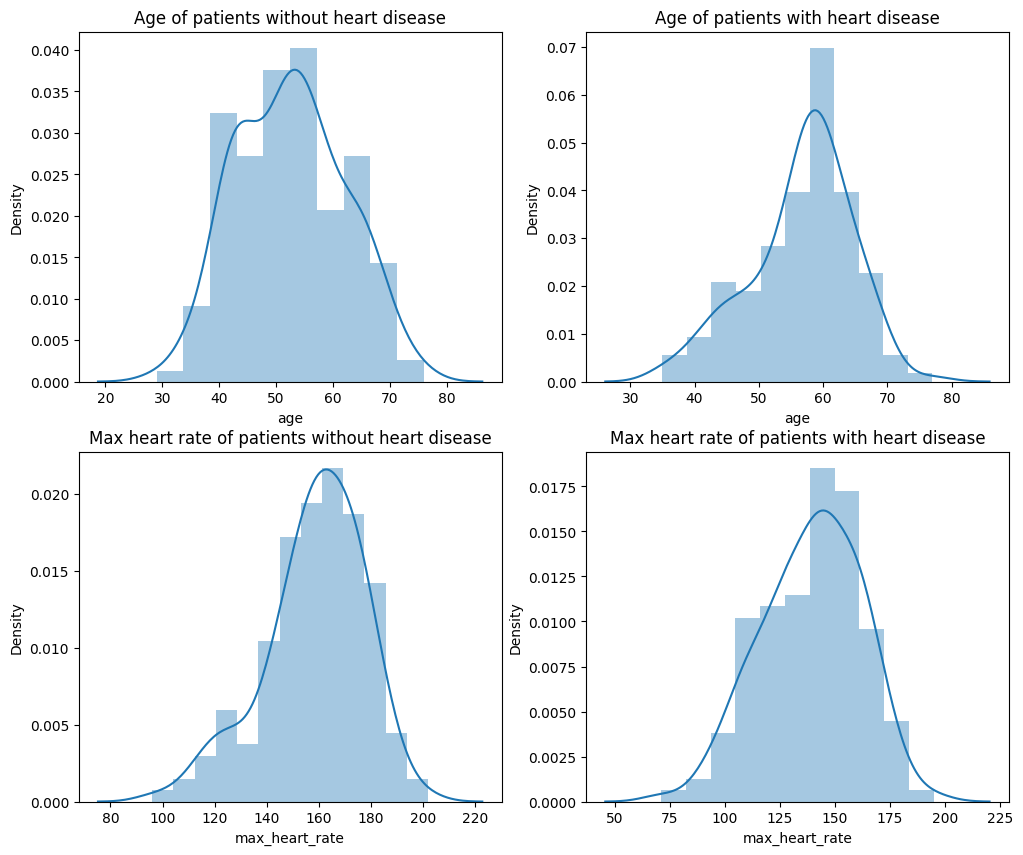

In [12]:
# create four distplots
plt.figure(figsize=(12,10))
plt.subplot(221)
sns.distplot(df[df['diagnosis']==0].age)
plt.title('Age of patients without heart disease')
plt.subplot(222)
sns.distplot(df[df['diagnosis']==1].age)
plt.title('Age of patients with heart disease')
plt.subplot(223)
sns.distplot(df[df['diagnosis']==0].max_heart_rate)
plt.title('Max heart rate of patients without heart disease')
plt.subplot(224)
sns.distplot(df[df['diagnosis']==1].max_heart_rate)
plt.title('Max heart rate of patients with heart disease')
plt.show()

Age distribution of healthy patients is much wider than ill people. The latter are at the highest risk in their sixties. 
Max heart rate distribution does not differ as much, but the risk peaks when *max_heart_rate* value is between 150 and 170. Higher values are more common for well patients. Below graphs will provide us with another perspective.

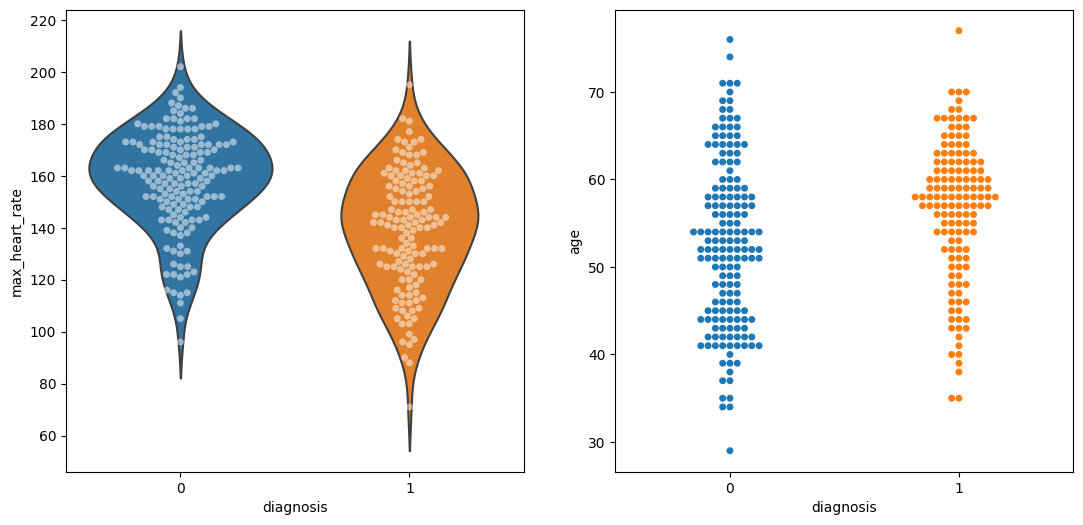

In [13]:
# create swarmplot inside the violinplot
plt.figure(figsize=(13,6))
plt.subplot(121)
sns.violinplot(x="diagnosis", y="max_heart_rate", data=df, inner=None)
sns.swarmplot(x='diagnosis', y='max_heart_rate', data=df, color='w', alpha=0.5)
plt.subplot(122)
sns.swarmplot(x='diagnosis', y='age', data=df)
plt.show()

### Categorical features

Let's take a closer look at categorical variables and see how they impact our target. 

In [14]:
# count ill vs healthy people grouped by sex
df.groupby(['sex','diagnosis'])['diagnosis'].count()

sex  diagnosis
0.0  0             72
     1             25
1.0  0             92
     1            114
Name: diagnosis, dtype: int64

In [15]:
# average number of diagnosed people grouped by number of blood vessels detected by fluoroscopy
df[['no_of_vessels','diagnosis']].groupby('no_of_vessels').mean()

,diagnosis
no_of_vessels,
0.0,0.261364
1.0,0.676923
2.0,0.815789
3.0,0.850000


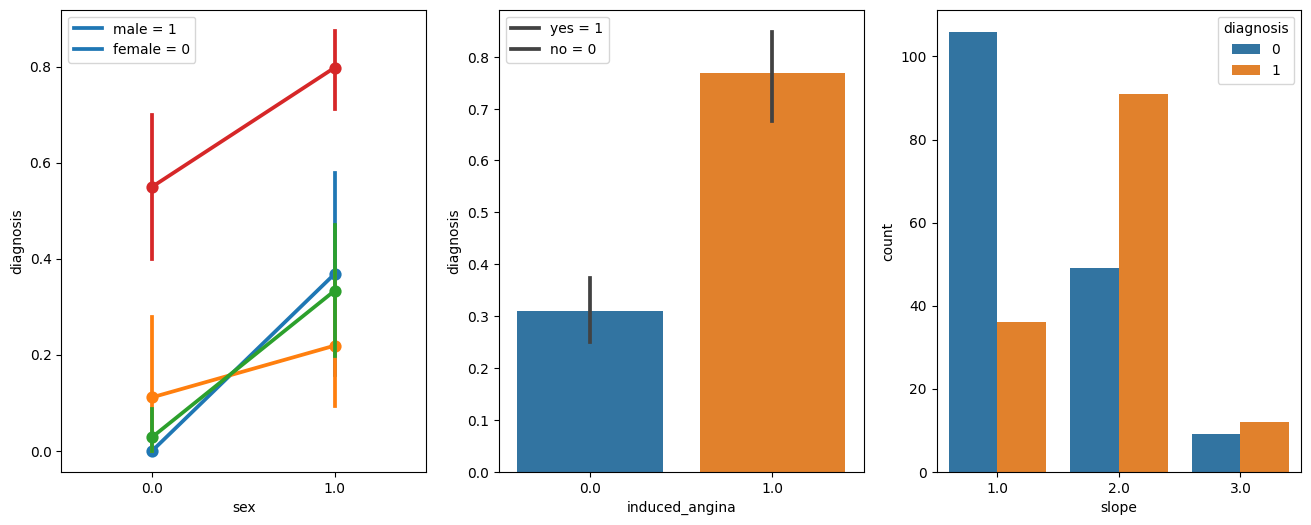

In [16]:
# create pairplot and two barplots
plt.figure(figsize=(16,6))
plt.subplot(131)
sns.pointplot(x="sex", y="diagnosis", hue='chest_pain', data=df)
plt.legend(['male = 1', 'female = 0'])
plt.subplot(132)
sns.barplot(x="induced_angina", y="diagnosis", data=df)
plt.legend(['yes = 1', 'no = 0'])
plt.subplot(133)
sns.countplot(x="slope", hue='diagnosis', data=df)
plt.show()

#### Observations:

1. Men are much more prone to get a heart disease than women.
2. The higher number of vessels detected through fluoroscopy, the higher risk of disease.
3. While soft chest pain may be a bad symptom of approaching problems with heart (especially in case of men), strong pain is a serious warning!
4. Risk of getting heart disease might be even 3x higher for someone who experienced exercise-induced angina.
5. The flat slope (value=2) and downslope (value=3) of the peak exercise indicates a high risk of getting disease

<Axes: xlabel='fasting_blood_sugar', ylabel='diagnosis'>

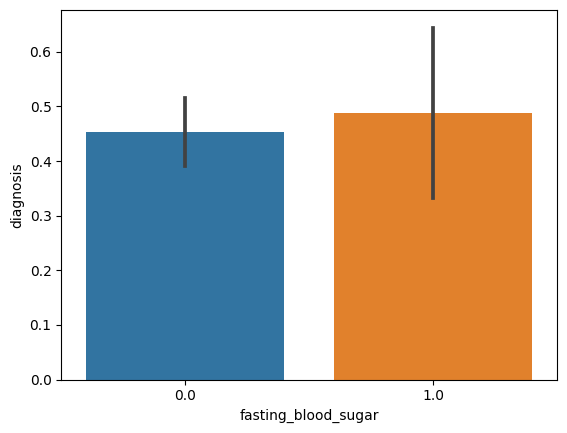

In [17]:
# create a barplot
sns.barplot(x="fasting_blood_sugar", y="diagnosis", data=df)

Almost even distribution suggests 'fasting blood sugar' to be a very weak feature for our prediction, therefore it could be excluded from our model. It is not likely that leaving this variable will improve our model accuracy, yet it shouldn't make it worse too. I decide to keep this variable as it is and confirm my hypothesis through checking feature importance of a few models. 

## 3.Data Preparation

In order to make our dataset compatible with machine learning algorithms contained in Sci-kit Learn library, first of all, we need to handle all missing data.

There are many options we could consider when replacing a missing value, for example:
- A constant value that has meaning within the domain, such as 0, distinct from all other values
- A value from another randomly selected record
- A mean, median or mode value for the column
- A value estimated by another predictive model

In [18]:
# show columns having missing values
df.isnull().sum()

age                     0
sex                     0
chest_pain              0
blood_pressure          0
serum_cholestoral       0
fasting_blood_sugar     0
electrocardiographic    0
max_heart_rate          0
induced_angina          0
ST_depression           0
slope                   0
no_of_vessels           4
thal                    2
diagnosis               0
dtype: int64

Both columns containing missing values are categorical. In such case, mode (most frequently occurring value in a given vector) is usually used for filling 'nans'. Let's follow this solution.

In [19]:
# fill missing values with mode
df['no_of_vessels'].fillna(df['no_of_vessels'].mode()[0], inplace=True)
df['thal'].fillna(df['thal'].mode()[0], inplace=True)

Having clean data, a label can be separated from the data frame. It is also a good moment to split our data train and test sets. I will allocate 30% of the entire data to test set, which is typically considered as a standard split for this size of dataset.

In [20]:
# extract the target variable
X, y = df.iloc[:, :-1], df.iloc[:, -1]
print(X.shape)
print(y.shape)

(303, 13)
(303,)


In [21]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2606)
print ("train_set_x shape: " + str(X_train.shape))
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_x shape: " + str(X_test.shape))
print ("test_set_y shape: " + str(y_test.shape))

train_set_x shape: (212, 13)
train_set_y shape: (212,)
test_set_x shape: (91, 13)
test_set_y shape: (91,)


Data needs to be normalized or standardized before applying to machine learning algorithms. Standardization scales the data and gives information on how many standard deviations the data is placed from its mean value. Effectively, the mean of the data (µ) is 0 and the standard deviation (σ) is 1.

In [22]:
# scale feature matrices
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Modelling and predicting with Machine Learning

The main goal of the entire project is to predict heart disease occurrence with the highest accuracy. In order to achieve this, we will test several classification algorithms. This section includes all results obtained from the study and introduces the best performer according to accuracy metric. I have chosen several algorithms typical for solving supervised learning problems throughout classification methods.

First of all, let's equip ourselves with a handy tool that benefits from the cohesion of SciKit Learn library and formulate a general function for training our models. The reason for displaying accuracy on both, train and test sets, is to allow us to evaluate whether the model overfits or underfits the data (so-called bias/variance tradeoff). 

In [23]:
def train_model(X_train, y_train, X_test, y_test, classifier, **kwargs):
    
    """
    Fit the chosen model and print out the score.
    
    """
    
    # instantiate model
    model = classifier(**kwargs)
    
    # train model
    model.fit(X_train,y_train)
    
    # check accuracy and print out the results
    fit_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)
    
    print(f"Train accuracy: {fit_accuracy:0.2%}")
    print(f"Test accuracy: {test_accuracy:0.2%}")
    
    return model

### K-Nearest Neighbours (KNN)

K-Nearest Neighbors algorithm is a non-parametric method used for classification and regression. The principle behind nearest neighbour methods is to find a predefined number of training samples closest in distance to the new point and predict the label from these.

In [24]:
# KNN
model = train_model(X_train, y_train, X_test, y_test, KNeighborsClassifier)

Train accuracy: 88.21%
Test accuracy: 86.81%


Despite its simplicity, the result is very promising. Let's see if KNN can perform even better by trying different 'n_neighbours' inputs.

In [25]:
# Seek optimal 'n_neighbours' parameter
for i in range(1,10):
    print("n_neigbors = "+str(i))
    train_model(X_train, y_train, X_test, y_test, KNeighborsClassifier, n_neighbors=i)

n_neigbors = 1
Train accuracy: 100.00%
Test accuracy: 74.73%
n_neigbors = 2
Train accuracy: 87.74%
Test accuracy: 79.12%
n_neigbors = 3
Train accuracy: 90.57%
Test accuracy: 83.52%
n_neigbors = 4
Train accuracy: 87.74%
Test accuracy: 84.62%
n_neigbors = 5
Train accuracy: 88.21%
Test accuracy: 86.81%
n_neigbors = 6
Train accuracy: 85.38%
Test accuracy: 86.81%
n_neigbors = 7
Train accuracy: 87.26%
Test accuracy: 86.81%
n_neigbors = 8
Train accuracy: 85.38%
Test accuracy: 85.71%
n_neigbors = 9
Train accuracy: 86.32%
Test accuracy: 85.71%


It turns out that default value of n_neighbours (5) is optimal. 

### Decision Trees

DT algorithm creates a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. It is simple to understand and interpret and it's possible to visualize how important a particular feature was for our tree.

Train accuracy: 100.00%
Test accuracy: 75.82%


<Axes: >

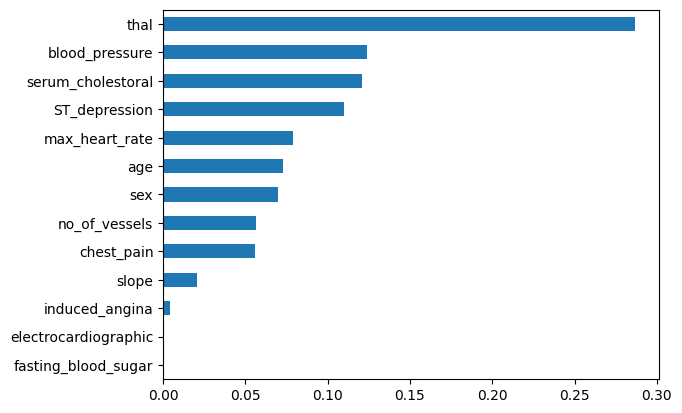

In [26]:
# Decision Tree
model = train_model(X_train, y_train, X_test, y_test, DecisionTreeClassifier, random_state=2606)

# plot feature importances
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh()

- Variable 'thal' turns out to be a significantly important feature.
- Remember my hypothesis that 'fasting_blood_sugar" is a very weak feature? Above graph confirms this clearly.
- Decision tree model learns the train set perfectly, and at the same time is entirely overfitting the data, what results in poor prediction. Other values of 'max_depth' parameter need to be tried out. 

In [27]:
# Check optimal 'max_depth' parameter
for i in range(1,8):
    print("max_depth = "+str(i))
    train_model(X_train, y_train, X_test, y_test, DecisionTreeClassifier, max_depth=i, random_state=2606)

max_depth = 1
Train accuracy: 76.89%
Test accuracy: 74.73%
max_depth = 2
Train accuracy: 78.30%
Test accuracy: 72.53%
max_depth = 3
Train accuracy: 87.74%
Test accuracy: 76.92%
max_depth = 4
Train accuracy: 91.98%
Test accuracy: 78.02%
max_depth = 5
Train accuracy: 94.81%
Test accuracy: 78.02%
max_depth = 6
Train accuracy: 97.17%
Test accuracy: 79.12%
max_depth = 7
Train accuracy: 97.64%
Test accuracy: 75.82%


With max_depth set as 6, the score went to almost 80%. By now, KNN outperforms Decision Tree.

### Logistic Regression

Logistic regression is a basic technique in statistical analysis that attempts to predict a data value based on prior observations. A logistic regression algorithm looks at the relationship between a dependent variable and one or more dependent variables.

In [28]:
# Logistic Regression
model = train_model(X_train, y_train, X_test, y_test, LogisticRegression)

Train accuracy: 85.85%
Test accuracy: 85.71%


Negligible difference between train and test score tells us as that model performs at the optimal level. Although the result itself is slightly lower than KNN, yet is still satisfactory. 

### Gaussian Naive Bayes

In machine learning, naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features.

In [29]:
#Gaussian Naive Bayes
model = train_model(X_train, y_train, X_test, y_test, GaussianNB)

Train accuracy: 85.38%
Test accuracy: 86.81%


This model produced the same result as leading KNN algorithm. While it slightly underfits the data, this model doesn't offer any hyperparameters for tuning and improve overall performance.

### Support Vector Machines

Support Vector Machines are perhaps one of the most popular machine learning algorithms. They are the go-to method for a high-performing algorithm with a little tuning. At first, let's try it on default settings.

In [30]:
# Support Vector Machines
model = train_model(X_train, y_train, X_test, y_test, SVC)

Train accuracy: 92.92%
Test accuracy: 82.42%


The above numbers are not remarkable by any means. I will adjust two parameters, "C", and 'kernel' to take full advantage of SVM power.

In [31]:
# tuned SVM
model = train_model(X_train, y_train, X_test, y_test, SVC, C=0.05, kernel='linear')

Train accuracy: 84.91%
Test accuracy: 87.91%


With impressive accuracy of almost 88%, Support Vector Machines are taking the lead!

### Random Forests

Random forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Train accuracy: 100.00%
Test accuracy: 86.81%


<Axes: >

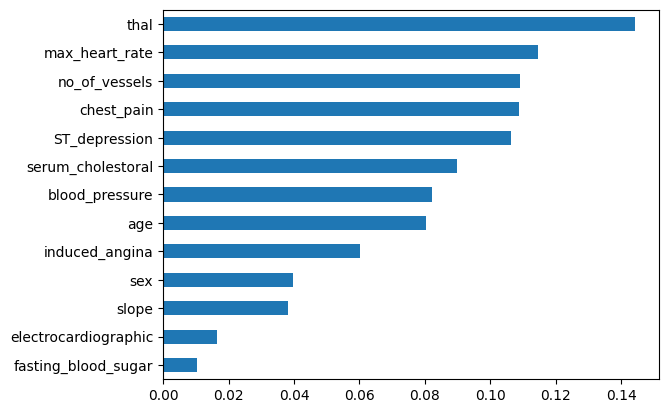

In [32]:
# Random Forests
model = train_model(X_train, y_train, X_test, y_test, RandomForestClassifier, random_state=2606)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh()

This result did not meet our expectations. Altering 'n_estimators' parameter will surely pull out more of this strong algorithm. 

In [33]:
# tuned Random Forests
model = train_model(X_train, y_train, X_test, y_test, RandomForestClassifier, n_estimators=110, random_state=2606)

Train accuracy: 100.00%
Test accuracy: 87.91%


While it is typical for Random Forests to perfectly learn and fit into training data, the test accuracy achieved outstanding 89%!

## 5. Conclusion

The goal of the project was to compare different machine learning algorithms and predict if a certain person, given various personal characteristics and symptoms, will get heart disease or not. Here are the final results.

In [34]:
# initialize an empty list
accuracy = []

# list of algorithms names
classifiers = ['KNN', 'Decision Trees', 'Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forests']

# list of algorithms with parameters
models = [KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(max_depth=6, random_state=2606), LogisticRegression(), 
        GaussianNB(), SVC(C=0.05, kernel='linear'), RandomForestClassifier(n_estimators=110, random_state=2606)]

# loop through algorithms and append the score into the list
for i in models:
    model = i
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    accuracy.append(score)

In [35]:
# create a dataframe from accuracy results
summary = pd.DataFrame({'accuracy':accuracy}, index=classifiers)       
summary

,accuracy
KNN,0.868132
Decision Trees,0.791209
Logistic Regression,0.857143
Naive Bayes,0.868132
SVM,0.879121
Random Forests,0.879121


It does not come as a surprise that the more complex algorithms like SVM and Random Forests generated better results compared to the basic ones. It is worth to emphasize that in most cases hyperparameter tuning is essential to achieve robust results out of these techniques. By producing decent results, simpler methods proved to be useful as well. 

Machine learning has absolutely bright future in medical field. Just imagine a place where heart disease experts are not available. With just basic information about a certain patient's medical history, we may quite accurately predict whether a disease will occur or not.